**COMP0120 Project Code - Support Vector Machines (SVMs)**

**John Duffy, Student Number: 19154676**

In [98]:
# Import libraries common to whole project.

import matplotlib.pyplot as plt
import numpy as np

In [99]:
# Load Iris dataset.

from sklearn import datasets
iris = datasets.load_iris()
X = iris["data"]
y = iris["target"]
y_names = iris["target_names"]

# Introduction

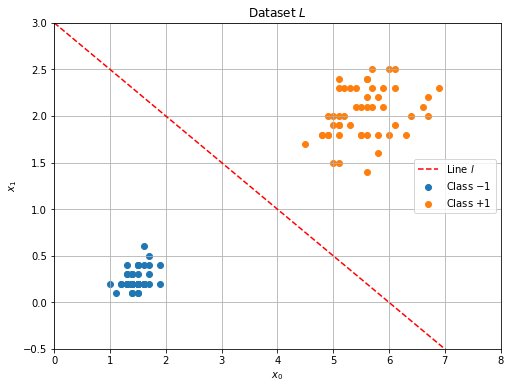

In [100]:
# intro_0.pdf

labels = ["Class $-1$", "Class $+1$"]
plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)
for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 3.0
x1 = m * x0 + c
plt.plot(x0, x1, "--r", label="Line $l$")
plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_0.pdf")
plt.show()

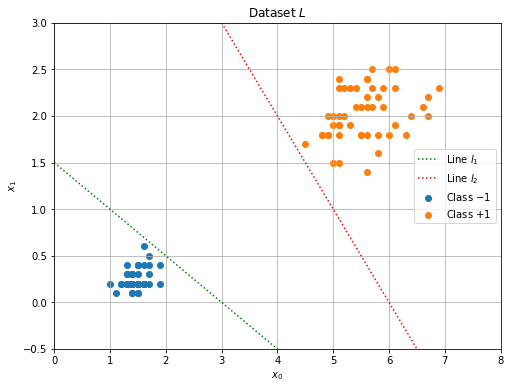

In [101]:
# intro_02.pdf

labels = ["Class $-1$", "Class $+1$"]
plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)
for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 1.5
x1 = m * x0 + c
plt.plot(x0, x1, ":g", label="Line $l_1$")
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -1
c = 6
x1 = m * x0 + c
plt.plot(x0, x1, ":r", label="Line $l_2$")
plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_1.pdf")
plt.show()

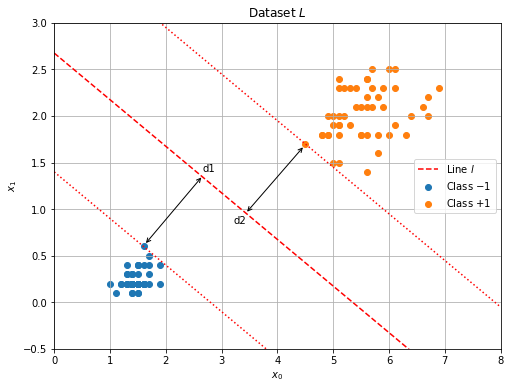

In [102]:
# intro_03.pdf

labels = ["Class $-1$", "Class $+1$"]

plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)

for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 1.4
x1 = m * x0 + c
plt.plot(x0, x1, ":r")

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 3.95
x1 = m * x0 + c
plt.plot(x0, x1, ":r")

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 2.675
x1 = m * x0 + c
plt.plot(x0, x1, "--r", label="Line $l$")

#plt.annotate("", xy=(0.80, 1.0), xytext=(2.9, 2.5), arrowprops=dict(arrowstyle="<->"))

plt.annotate("d1", xy=(1.62, 0.62), xytext=(2.65, 1.4), arrowprops=dict(arrowstyle="<->"))
plt.annotate("d2", xy=(4.48, 1.68), xytext=(3.21, 0.85), arrowprops=dict(arrowstyle="<->"))

plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_2.pdf")
plt.show()

# Mathematical Setting

## Linear Binary Classification

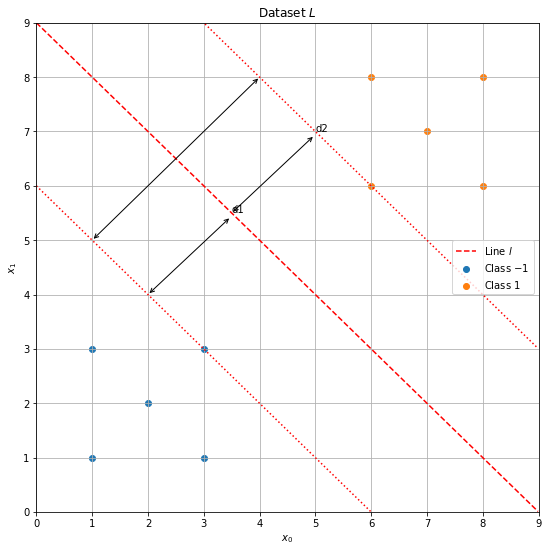

In [103]:
# linear_binary_0.pdf

plt.figure(figsize=(9, 9))
plt.xlim(0, 9)
plt.ylim(0, 9)

X = np.array([[1.0, 1.0], [1.0, 3.0], [2.0, 2.0], [3.0, 1.0], [3.0, 3.0],
              [6.0, 6.0], [6.0, 8.0], [8.0, 6.0], [8.0, 8.0], [7.0, 7.0]],
             dtype=np.float64)
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
y_names = ["Class $-1$", "Class $1$"]

for i in np.sort(np.unique(y)):
    plt.scatter(X[y == i, 0], X[y == i, 1], label=y_names[i])

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -1.0
c = 9.0
x1 = m * x0 + c
plt.plot(x0, x1, "--r", label="Line $l$")

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -1.0
c = 6.0
x1 = m * x0 + c
plt.plot(x0, x1, ":r")

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -1.0
c = 12.0
x1 = m * x0 + c
plt.plot(x0, x1, ":r")

plt.annotate("", xy=(1.0, 5.0), xytext=(4.0, 8.0), arrowprops=dict(arrowstyle="<->"))
plt.annotate("d1", xy=(2.0, 4.0), xytext=(3.5, 5.5), arrowprops=dict(arrowstyle="<->"))
plt.annotate("d2", xy=(3.5, 5.5), xytext=(5.0, 7.0), arrowprops=dict(arrowstyle="<->"))

plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid(zorder=0)
plt.savefig("linear_binary_0.pdf")
plt.show()

In [104]:
# Sepal Data
#plt.figure(figsize=(8, 6))
#for i in np.sort(np.unique(y)):
#    plt.scatter(X[y == i, 0], X[y == i, 1], label=y_names[i])
#plt.title("Sepal Data")
#plt.xlabel("Sepal Length")
#plt.ylabel("Sepal Width")
#plt.legend()
#plt.grid(zorder=0)
#plt.savefig("iris_sepal.pdf")
#plt.show()

# Petal Data
#plt.figure(figsize=(8, 6))
#for i in np.sort(np.unique(y)):
#    plt.scatter(X[y == i, 2], X[y == i, 3], label=y_names[i])
#plt.title("Petal Data")
#plt.xlabel("Petal Length")
#plt.ylabel("Petal Width")
#plt.legend()
#plt.grid(zorder=0)
#plt.savefig("iris_petal.pdf")
#plt.show()

In [105]:
#plt.figure(figsize=(8, 6))
#for i in np.sort(np.unique(y)):
#    plt.scatter(X[y == i, 2], X[y == i, 3], label=y_names[i])
#x = np.arange(1, 7, 0.01)
#m = -1
#c = 2.5
#y = m * x + c
#plt.plot(x, y)
#plt.title("Petal Data")
#plt.xlabel("Petal Length")
#plt.ylabel("Petal Width")
#plt.legend()
#plt.grid()
#plt.savefig("iris_petal.pdf")
#plt.show()

In [106]:
# Implementation of steepest_descent and backtracking.

def backtracking(f, df, x, p, alpha0=1.0, rho=0.1, c1=1e-4):
    alpha = alpha0
    alphas = [alpha]
    while f(x + alpha * p) > f(x) + c1 * alpha * np.dot(df(x), p):
        alpha = rho * alpha
        alphas.append(alpha)
    return alphas

def steepest_descent(f, df, x0, tol=1e-6):
    x = x0
    xs = [x]
    i = 0
    while True:
        i += 1
        p = -1.0 * df(x)
        alphas = backtracking(f, df, x, p)
        x_1 = x
        x = x + alphas[-1] * p
        xs.append(x)
        if np.linalg.norm(x - x_1) / np.linalg.norm(x_1) < tol:
            break
    return (i, xs)

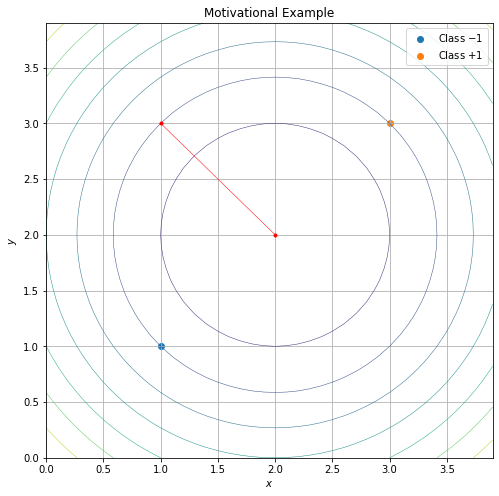

Minimum:    [2.0, 2.0]
Iterations: 2




In [107]:
# motivate.pdf

f = lambda x: 0.5*(x[0]**2 + x[1]**2) - 2 * x[0] - 2 * x[1] + 2

df = lambda x: np.array([x[0] - 2, x[1] - 2])

d2f = lambda x: np.array([[1, 0], [0, 1]])


x0 = np.array([1.0,3.0])
iters, xs = steepest_descent(f, df, x0)

x = np.arange(0, 4, 0.1)
y = np.arange(0, 4, 0.1)
xx, yy = np.meshgrid(x, y)
z = 0.5*(xx**2 + yy**2) - 2*xx -2*yy + 2

plt.figure(figsize=(8, 8))
plt.contour(x,y,z, linewidths=0.5)
plt.scatter(1, 1, label="Class $-1$")
plt.scatter(3, 3, label="Class $+1$")

x_plot = []
y_plot = []
for i in range(iters):
    x_plot.append(xs[i][0])
    y_plot.append(xs[i][1])
plt.plot(x_plot, y_plot, '-ro', linewidth=0.5, markersize=3)

plt.title("Motivational Example")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.grid()
plt.savefig("motivate.pdf")
plt.show()

print("Minimum:    [{}, {}]".format(xs[-1][0], xs[-1][1]))
print("Iterations: {}".format(iters))
print("\n")

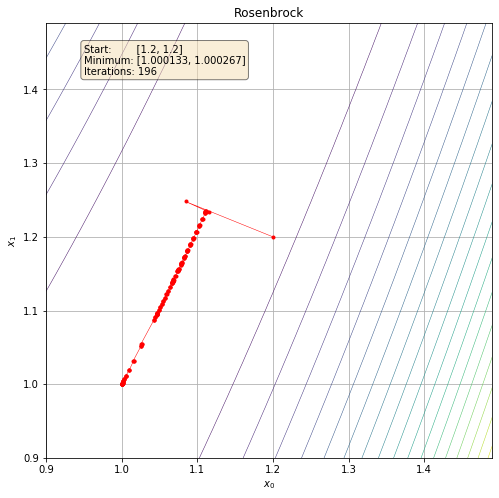

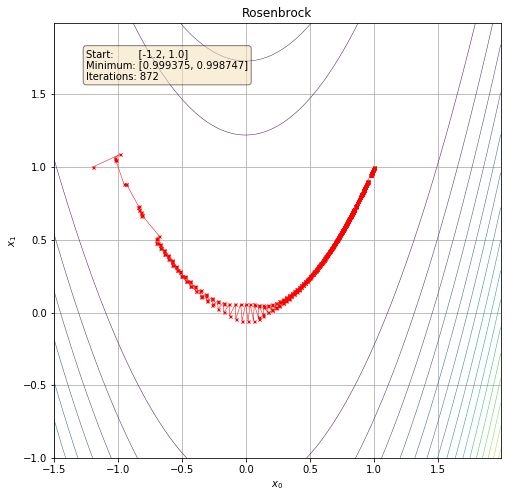

Minimum:    [0.9993746097756836, 0.9987471061235461]
Iterations: 872




In [135]:
# Rosenbrock

a = 1
b = 100

f = lambda x: (a - x[0])**2 + b*(x[1] - x[0]**2)**2

df = lambda x: np.array([-2.0 * (a - x[0]) - 4.0 * b * x[0] * (x[1] - x[0]**2),
                         2.0 * b * (x[1] - x[0]**2)])

# rosenbrock_0.pdf

x0 = np.array([1.2, 1.2], dtype=np.float64)
iters, xs = steepest_descent(f, df, x0)

x = np.arange(0.9, 1.5, 0.01)
y = np.arange(0.9, 1.5, 0.01)
xx, yy = np.meshgrid(x, y)
z = (a - xx)**2 + b * (yy - xx**2)**2

plt.figure(figsize=(8, 8))
plt.contour(x,y,z, linewidths=0.5, levels=20)

x_plot = []
y_plot = []
for i in range(iters):
    x_plot.append(xs[i][0])
    y_plot.append(xs[i][1])
plt.plot(x_plot, y_plot, '-ro', linewidth=0.5, markersize=3)

plt.title("Rosenbrock")

s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
s3 = "Iterations: {}".format(iters)
box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.95, 1.42, s1 + s2 + s3, bbox=box_prop)

plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()
plt.savefig("rosenbrock_0.pdf")
plt.show()


# rosenbrock_1.pdf

x0 = np.array([-1.2, 1.0], dtype=np.float64)
iters, xs = steepest_descent(f, df, x0)

x = np.arange(-1.5, 2.0, 0.01)
y = np.arange(-1.0, 2.0, 0.01)
xx, yy = np.meshgrid(x, y)
z = (a - xx)**2 + b * (yy - xx**2)**2

plt.figure(figsize=(8, 8))
plt.contour(x,y,z, linewidths=0.5, levels=20)

x_plot = []
y_plot = []
for i in range(iters):
    x_plot.append(xs[i][0])
    y_plot.append(xs[i][1])
plt.plot(x_plot, y_plot, '-rx', linewidth=0.5, markersize=3)

plt.title("Rosenbrock")

s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
s3 = "Iterations: {}".format(iters)
box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-1.25, 1.6, s1 + s2 + s3, bbox=box_prop)

plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()
plt.savefig("rosenbrock_1.pdf")
plt.show()

print("Minimum:    [{}, {}]".format(xs[-1][0], xs[-1][1]))
print("Iterations: {}".format(iters))
print("\n")